# Project name: [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

# Objective

Get better than 0.994 score on [Public Leaderboard](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/leaderboard)

# Version

In [1]:
__ver__ = "0.3"

# Setup

In [2]:
import numpy as np
import pandas as pd
import catboost
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels as sm
from pmdarima import arima
%matplotlib inline 

import itertools
import warnings
import sys

def downcaster(df):
    for col in df:
        if issubclass(df[col].dtype.type, np.floating):
            df.loc[:, col] = pd.to_numeric(df.loc[:, col], downcast='float')
        if issubclass(df[col].dtype.type, np.integer):
            df.loc[:, col]   = pd.to_numeric(df.loc[:, col], downcast='integer')
    return df

# Data load

In [3]:
# path
cat_path = "./raw_data/item_categories.csv"
items_path = "./raw_data/items.csv"
shop_path = "./raw_data/shops.csv"
sales_path = "./raw_data/sales_train.csv.gz"
test_path = "./raw_data/test.csv.gz"

In [4]:
# load
cat = pd.read_csv(cat_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shop_path)
sales_params = dict(parse_dates=[0], infer_datetime_format = True, dayfirst=True)
sales = pd.read_csv(sales_path, **sales_params)
# load and save ID in index
test = pd.read_csv(test_path).set_index('ID')

# Data preprocessing

 ## Categories

In [5]:
cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
# item_category_name can be split into category_group and sub_category
cat_split = cat.item_category_name.str.split(" - ")
cat["category_group"] = cat_split.apply(lambda x:  x[0])
cat["sub_category"] = cat_split.apply(lambda x:  x[1] if len(x) == 2 else x[0])

In [7]:
# Drop, encode and downcast
cat = cat.drop("item_category_name", axis=1)
cat.category_group = preprocessing.LabelEncoder().fit_transform(cat.category_group)
cat.sub_category = preprocessing.LabelEncoder().fit_transform(cat.sub_category)
cat = downcaster(cat)
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
item_category_id    84 non-null int8
category_group      84 non-null int8
sub_category        84 non-null int8
dtypes: int8(3)
memory usage: 332.0 bytes


## Shops

In [8]:
# looks like dublicated shops 
shops.iloc[[0, 57, 1, 58, 10, 11]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


#### Shops 0 and 57

In [9]:
# shop 0 ends at 1 date_block_num               
sales[sales.shop_id == 0].date_block_num.unique()

array([0, 1])

In [10]:
# shop 57 starts at 2 date_block_num
sales[sales.shop_id == 57].date_block_num.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [11]:
# no shop 0 in test set
0 in test.shop_id.unique()

False

In [12]:
# replace shop 0 with 57
sales.loc[sales.shop_id == 0, "shop_id"] = 57

#### Shops 1 and 58

In [13]:
# shop 1 ends at 1 date_block_num               
sales[sales.shop_id == 1].date_block_num.unique()

array([0, 1])

In [14]:
# shop 58 starts at 2 date_block_num
sales[sales.shop_id == 58].date_block_num.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [15]:
# no shop 1 in test set
1 in test.shop_id.unique()

False

In [16]:
# replase shop 0 with 58
sales.loc[sales.shop_id == 1, "shop_id"] = 58

#### Shops 10 and 11

In [17]:
# shop 11 exists only at 25 date_block_num
sales[sales.shop_id == 11].date_block_num.unique()

array([25])

In [18]:
# no 25 date_block_num for shop 10
sales[sales.shop_id == 10].date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33])

In [19]:
# no shop 11 in test set
11 in test.shop_id.unique()

False

In [20]:
# replase shop 11 with 10
sales.loc[sales.shop_id == 11, "shop_id"] = 10

In [21]:
# drop bad shops
shops.drop([0, 1, 11], inplace=True)

#### Shops featues

In [22]:
# First part of shop_name is city
shops.shop_name.str.split().apply(lambda x: x[0]).unique()

array(['Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Выездная',
       'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга', 'Коломна',
       'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [23]:
shops['city'] = shops.shop_name.str.split().apply(lambda x: x[0])

In [24]:
# There are four spetial cases:
#       'Выездная Торговля' =        non-shop trading 9
#       'Распродажа' =               sale 20
#       'Интернет-магазин' =         internet shop 12
#       'Цифровой склад 1С-Онлайн' = central stock 55
shops['trading'] = False
shops.loc[9, 'trading'] = True
shops['sale'] = False
shops.loc[20, 'sale'] = True
shops['i_shop'] = False
shops.loc[12, 'i_shop'] = True
shops['c_shop'] = False
shops.loc[55, 'c_shop'] = True

In [25]:
# Drop, encode and downcast
shops.drop("shop_name", axis=1, inplace=True)
shops.city = preprocessing.LabelEncoder().fit_transform(shops.city)
shops = downcaster(shops)
shops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 2 to 59
Data columns (total 6 columns):
shop_id    57 non-null int8
city       57 non-null int8
trading    57 non-null bool
sale       57 non-null bool
i_shop     57 non-null bool
c_shop     57 non-null bool
dtypes: bool(4), int8(2)
memory usage: 3.3 KB


## Items

In [26]:
# Drop, encode and downcast
items.drop("item_name", axis=1, inplace=True)
items = downcaster(items)
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 2 columns):
item_id             22170 non-null int16
item_category_id    22170 non-null int8
dtypes: int16(1), int8(1)
memory usage: 65.0 KB


## Make sales like Test

In [27]:
# Aggregate
state_columns = ["date_block_num", "shop_id", "item_id"]
sales.drop("item_price", axis=1, inplace=True)
sales = sales.groupby(state_columns, as_index=False).sum()

In [28]:
# Rename target
new_columns = sales.columns.tolist()
new_columns[-1] = "y"
sales.columns = new_columns

In [29]:
# Test set consists of 5100 items for 42 shops
(
    len(test.item_id.unique()), 
    len(test.shop_id.unique()), 
    len(test.item_id.unique()) * (len(test.shop_id.unique())) == len(test)
)

(5100, 42, True)

In [30]:
# Sale set consists of 21807 items for 57 shops
len(sales.item_id.unique()), len(sales.shop_id.unique())

(21807, 57)

In [31]:
# There are new items in test set
len(set(test.item_id.unique()) - set(sales.item_id.unique()))

363

In [32]:
# Let's make training set like test set - add all sold items to every working shop for every date_block_num
all_states = []
for num in sorted(sales.date_block_num.unique()):
    month_sales = sales.loc[sales.date_block_num == num]
    test_combinations = itertools.product(
        [num],
        sorted(month_sales.shop_id.unique()),
        sorted(test.item_id.unique())
    )
    all_states.extend(list(test_combinations))
data = pd.DataFrame(
    all_states,
    columns=state_columns
)
data = data.merge(sales, on=state_columns, how="left")
data.y = data.y.fillna(0)

In [33]:
# downcast and clip to [0, 20]
data.loc[:, "y"] = data.y.clip(0, 20)
data = downcaster(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8088600 entries, 0 to 8088599
Data columns (total 4 columns):
date_block_num    int8
shop_id           int8
item_id           int16
y                 float32
dtypes: float32(1), int16(1), int8(2)
memory usage: 123.4 MB


## Stack Sales and Test

In [34]:
# add date_block_num to test
test_date_block = data.date_block_num.max() + 1
test["date_block_num"] = test_date_block
test = downcaster(test)

In [35]:
# stack train and test data
data = pd.concat([data, test], axis=0, sort=False)

## Merge all data

In [36]:
data = data.merge(shops, how="left", on="shop_id")
data = data.merge(items, how="left", on="item_id")
data = data.merge(cat, how="left", on="item_category_id")

In [37]:
# Drop constant features
data = data.loc[:, data.nunique() != 1]

# Feature generation

### Seasonality

In [38]:
montly_agg = data.groupby("date_block_num")["y"].sum().iloc[:-1]

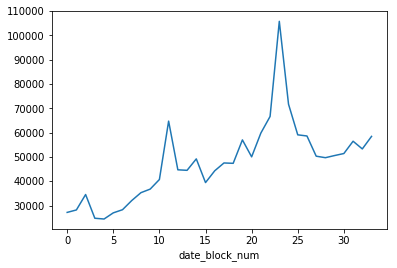

In [39]:
# Seasonality
montly_agg.plot()

In [40]:
# Add month feature
data["month"] = data.date_block_num % 12

In [41]:
# Add NY feature
data["NY"] = data["month"] == 11

In [42]:
# Weak sign of unit root
sm.tsa.stattools.adfuller(montly_agg)

(-2.3274906760427663,
 0.1632548907098001,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 499.9685532749338)

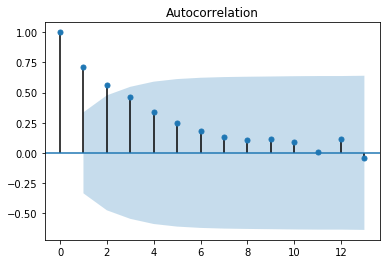

In [43]:
_ = sm.graphics.tsaplots.plot_acf(montly_agg, lags=13)

In [44]:
def make_lags(df, lag_col_name, lags):
    for i in sorted(lags):
        lagger = df[state_columns + [lag_col_name]]
        lagger.loc[:, "date_block_num"] = lagger["date_block_num"] + i
        lagger.columns = lagger.columns[:-1].tolist() + [f"{lag_col_name}_{i}"]
        df = df.merge(lagger, on=state_columns, how='left')
    return df

In [45]:
# Add some lags and diff
data = make_lags(data, "y", [1, 2, 3, 4, 5, 6])

/Users/WLMike/Documents/PycharmProjects/How_to_Win_Kagglers/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Save processed data

In [46]:
processed_path = f"./processed_data/data_{__ver__}.pickle"
data.to_pickle(processed_path)

## Load processed data

In [58]:
data = pd.read_pickle(processed_path)

## Validation strategies

Validation strategy:

* Train - all months except last one in the training set
* Validate - a last month in the training set
* Test - a test set

In [59]:
# Drop bad features
data.drop(["sale", "i_shop", "c_shop", "trading", "city", "month"], axis=1, inplace=True)
l2_leaf_reg = 6

In [60]:
val_range = 1

x_train = data[data.date_block_num < test_date_block - val_range].drop("y", axis=1)
y_train = data.loc[data.date_block_num < test_date_block - val_range, "y"]

mask = (test_date_block - val_range <= data.date_block_num) & (data.date_block_num < test_date_block)
x_valid = data[mask].drop("y", axis=1)
y_valid = data.loc[mask, "y"]

x_test = data[data.date_block_num == test_date_block].drop("y", axis=1)

In [61]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7864200 entries, 0 to 7864199
Data columns (total 13 columns):
date_block_num      int8
shop_id             int8
item_id             int16
item_category_id    int8
category_group      int8
sub_category        int8
NY                  bool
y_1                 float32
y_2                 float32
y_3                 float32
y_4                 float32
y_5                 float32
y_6                 float32
dtypes: bool(1), float32(6), int16(1), int8(5)
memory usage: 300.0 MB


In [62]:
cat_columns = [i for i, col in enumerate(x_train) if not issubclass(x_train[col].dtype.type, np.floating)]
cat_columns

[0, 1, 2, 3, 4, 5, 6]

In [1]:
clf_params = dict(
    random_state=284704,
    od_type="Iter",
    od_wait=20,
    verbose=10,
    learning_rate=0.1,
    iterations=200,
    task_type="GPU",
    l2_leaf_reg=l2_leaf_reg
)

if sys.platform == "darwin":
    del clf_params["task_type"]

clf = catboost.CatBoostRegressor(**clf_params)

fit_params = dict(
    X=x_train, 
    y=y_train,
    cat_features=cat_columns,
    eval_set=(x_valid, y_valid),
    plot=True
)

if sys.platform != "darwin":
    del fit_params["plot"]

clf.fit(**fit_params)

NameError: name 'l2_leaf_reg' is not defined

In [2]:
bestTest = 0.976 # 1.02337

In [66]:
clf.get_feature_importance(prettified=True)

[('y_1', 36.88218779183184),
 ('item_id', 15.851736834543551),
 ('date_block_num', 13.316841716491801),
 ('shop_id', 11.1534730379435),
 ('y_2', 7.664870546106049),
 ('y_3', 3.9561119549236126),
 ('item_category_id', 2.7161031898545662),
 ('NY', 2.1979249075698664),
 ('y_5', 2.161362871382702),
 ('category_group', 1.1437578427451505),
 ('sub_category', 1.1021083810906822),
 ('y_4', 0.9883671283370264),
 ('y_6', 0.8651537971796525)]

## Submission

In [67]:
sub_df = pd.DataFrame(
    clf.predict(x_test), 
    index=test.index, 
    columns=["item_cnt_month"]
).clip(0, 20)
sub_df.index.name = "ID"

In [68]:
sub_path = f"./submissions/submission_{__ver__}.csv"
sub_df.to_csv(sub_path)

## Hyperparameters tuning

Only if you don’t have any more ideas or you have spare computational resources

Average everything:

* Over random seed
* Or over small deviations from optimal parameters

## Ensembling

* Save all good models
* Make diverse models

* Averaging
* Weighted averaging
* Bagging (BaggingClassifier and BaggingRegressor from Sklearn, seed bagging)
* Boosting (AdaBoostClassifier from Sklearn)
* Stacking (Meta model should be modest)
* StackNet
    - Diversity of base algoritms
    - Diversity of base data
    - Simpler algoritms on higher levels
    - Feature engineering of meta feature (differences, std ...)
    - For every level 1model for 5-10 modelesin orivios level